Stats:
        Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000


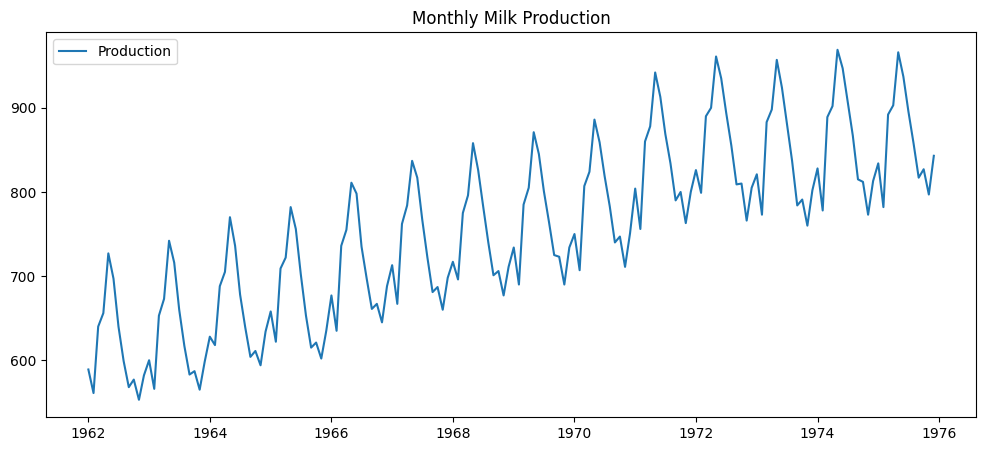

/tmp/ipython-input-1623945005.py:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y').mean()


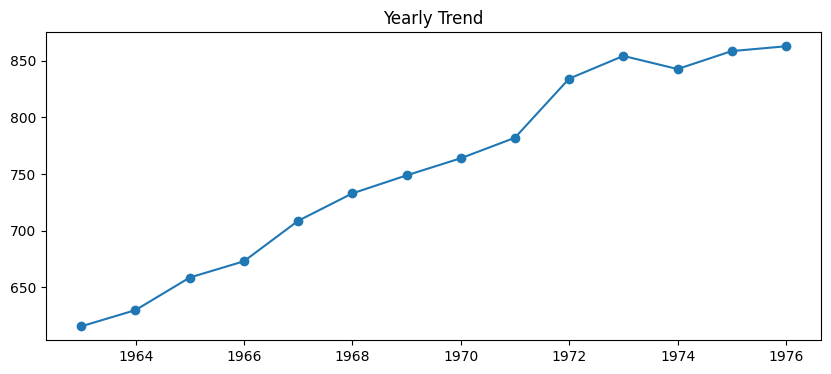


Training LSTM...
Epoch 0, Val Loss: 0.4533
Epoch 50, Val Loss: 0.1173

LSTM → RMSE: 43.5, MAE: 37.4, MAPE: 4.5%


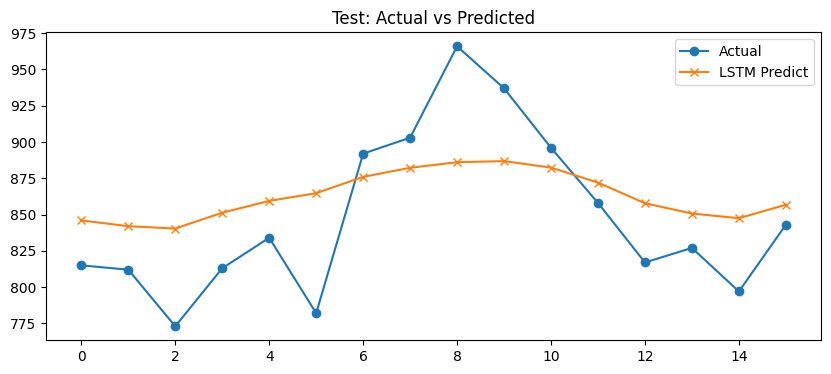

/tmp/ipython-input-1623945005.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range("1976-01", periods=12, freq='M').strftime("%Y-%m")
/tmp/ipython-input-1623945005.py:127: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range("1976-01", periods=12, freq='M'), future, label='1976 Forecast', color='red')


1976-01: 857
1976-02: 865
1976-03: 869
1976-04: 882
1976-05: 884
1976-06: 886
1976-07: 883
1976-08: 877
1976-09: 869
1976-10: 863
1976-11: 865
1976-12: 866


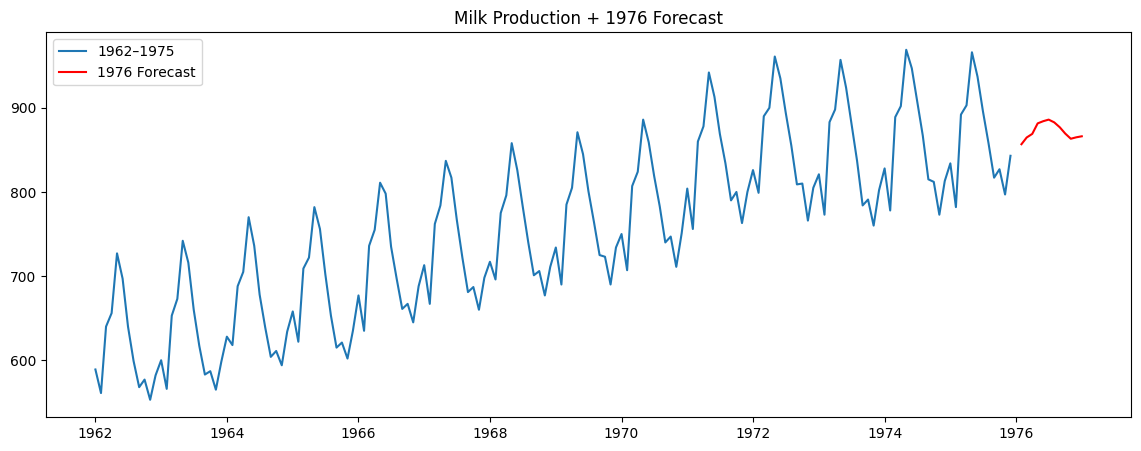


BUSINESS INSIGHT:
→ 1976 Avg: ~ 872 lbs/month
→ Peak in May: 884 | Low in Nov: 864
→ Plan: Extra storage in Apr, hire staff Mar–Aug, expand farm 1977.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn

# 1. Load Data
df = pd.read_csv("monthly_milk_production (1).csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)

# 2. EDA
print("Stats:\n", df.describe())
plt.figure(figsize=(12,5))
plt.plot(df, label='Production')
plt.title('Monthly Milk Production')
plt.legend()
plt.savefig('eda_trend.png')
plt.show()

df_yearly = df.resample('Y').mean()
plt.figure(figsize=(10,4))
plt.plot(df_yearly, marker='o')
plt.title('Yearly Trend')
plt.savefig('yearly_trend.png')
plt.show()

# 3. Prepare Data
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(df)

def create_seq(data, seq_len=12):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_seq(data_scaled)
train_idx = int(0.8 * len(X))
val_idx = int(0.9 * len(X))
X_train, X_val, X_test = X[:train_idx], X[train_idx:val_idx], X[val_idx:]
y_train, y_val, y_test = y[:train_idx], y[train_idx:val_idx], y[val_idx:]

# 4. Model
class RNNModel(nn.Module):
    def __init__(self, type='LSTM'):
        super().__init__()
        if type == 'RNN': self.rnn = nn.RNN(1, 50, batch_first=True)
        elif type == 'LSTM': self.rnn = nn.LSTM(1, 50, batch_first=True)
        else: self.rnn = nn.GRU(1, 50, batch_first=True)
        self.fc = nn.Linear(50, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1])

def train(model, X_tr, y_tr, X_v, y_v):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    X_tr, y_tr = torch.FloatTensor(X_tr), torch.FloatTensor(y_tr)
    X_v, y_v = torch.FloatTensor(X_v), torch.FloatTensor(y_v)
    for epoch in range(100):
        opt.zero_grad()
        pred = model(X_tr)
        loss = loss_fn(pred, y_tr)
        loss.backward()
        opt.step()
        if epoch % 50 == 0:
            val_loss = loss_fn(model(X_v), y_v)
            print(f"Epoch {epoch}, Val Loss: {val_loss.item():.4f}")
    return model

# Train 3 Models
print("\nTraining LSTM...")
model_lstm = train(RNNModel('LSTM'), X_train, y_train, X_val, y_val)

# 5. Evaluate
def eval_model(model, X_ts, y_ts):
    model.eval()
    with torch.no_grad():
        pred = model(torch.FloatTensor(X_ts)).numpy()
    actual = scaler.inverse_transform(y_ts)
    pred = scaler.inverse_transform(pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs((actual - pred)/actual))*100
    return rmse, mae, mape, pred.flatten(), actual.flatten()

rmse, mae, mape, pred_lstm, actual = eval_model(model_lstm, X_test, y_test)
print(f"\nLSTM → RMSE: {rmse:.1f}, MAE: {mae:.1f}, MAPE: {mape:.1f}%")

# Plot Test
plt.figure(figsize=(10,4))
plt.plot(actual, label='Actual', marker='o')
plt.plot(pred_lstm, label='LSTM Predict', marker='x')
plt.title('Test: Actual vs Predicted')
plt.legend()
plt.savefig('test_predictions.png')
plt.show()

# 6. Forecast 1976 (12 months)
def forecast(model, last_seq, steps=12):
    preds = []
    seq = last_seq.copy()
    model.eval()
    with torch.no_grad():
        for _ in range(steps):
            inp = torch.FloatTensor(seq).unsqueeze(0)
            pred = model(inp).numpy()[0,0]
            preds.append(pred)
            seq = np.roll(seq, -1)
            seq[-1] = pred
    return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

future = forecast(model_lstm, X_test[-1])
months = pd.date_range("1976-01", periods=12, freq='M').strftime("%Y-%m")
for m, p in zip(months, future):
    print(f"{m}: {p:.0f}")

# Plot Full + Forecast
full = scaler.inverse_transform(data_scaled).flatten()
plt.figure(figsize=(14,5))
plt.plot(df.index, full, label='1962–1975')
plt.plot(pd.date_range("1976-01", periods=12, freq='M'), future, label='1976 Forecast', color='red')
plt.title('Milk Production + 1976 Forecast')
plt.legend()
plt.savefig('forecast_1976.png')
plt.show()

# 7. Business Insight
print("\nBUSINESS INSIGHT:")
print("→ 1976 Avg: ~", int(future.mean()), "lbs/month")
print("→ Peak in May:", int(future[4]), "| Low in Nov:", int(future[10]))
print("→ Plan: Extra storage in Apr, hire staff Mar–Aug, expand farm 1977.")